In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, mean_squared_error
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")


In [9]:
def load_dataset(scaler="minmax", strategy="split"):
    """
    Carrega os datasets NSL-KDD com duas estratégias:
    - 'split': carrega apenas o arquivo de treino e faz split em treino e validação
    - 'merge': carrega treino e teste reais e faz codificação alinhada
    """
    assert scaler in ["minmax", "standard"], "Escala inválida"
    assert strategy in ["split", "merge"], "Estratégia deve ser 'split' ou 'merge'"
    
    base_path = f"../data/final/{scaler}"
    train_path = f"{base_path}/KDDTrain+_final_{scaler}.csv"
    test_path = f"{base_path}/KDDTest+_final_{scaler}.csv"

    if strategy == "split":
        df = pd.read_csv(train_path)
        print(f"[SPLIT] Escala usada: {scaler}")
        print("Dataset carregado:", df.shape)

        # Split em treino e validação
        df_train, df_test = train_test_split(
            df, test_size=0.2, random_state=1, stratify=df["attack_category"]
        )
        print("Train split:", df_train.shape)
        print("Validação split:", df_test.shape)

        return df_train.reset_index(drop=True), df_test.reset_index(drop=True)

    else:  # strategy == "merge"
        df_train = pd.read_csv(train_path)
        df_test = pd.read_csv(test_path)

        df_train["__origin__"] = "train"
        df_test["__origin__"] = "test"

        df_all = pd.concat([df_train, df_test], axis=0)

        origin = df_all["__origin__"]
        target = df_all["attack_category"]
        df_all = df_all.drop(columns=["__origin__", "attack_category"])

        df_all = pd.get_dummies(df_all)
        df_all = df_all.fillna(0)

        df_all["attack_category"] = target.values
        df_all["__origin__"] = origin.values

        df_train_final = df_all[df_all["__origin__"] == "train"].drop(columns="__origin__")
        df_test_final = df_all[df_all["__origin__"] == "test"].drop(columns="__origin__")

        print(f"[MERGE] Escala usada: {scaler}")
        print("Train final:", df_train_final.shape)
        print("Test final :", df_test_final.shape)

        return df_train_final.reset_index(drop=True), df_test_final.reset_index(drop=True)

In [10]:
# minmax or standard
# Estratégia de split (KDDTrain+ somente)

df_train, df_val = load_dataset("minmax", strategy="split")

X_train = df_train.drop(columns=["attack_category"])
y_train = df_train["attack_category"]

X_val = df_val.drop(columns=["attack_category"])
y_val = df_val["attack_category"]

# Estratégia para avaliação final real (KDDTrain+ e KDDTest+ juntos)
df_train_final, df_test_final = load_dataset("minmax", strategy="merge")

X_train_final = df_train_final.drop(columns=["attack_category"])
y_train_final = df_train_final["attack_category"]

X_test_final = df_test_final.drop(columns=["attack_category"])
y_test_final = df_test_final["attack_category"]

[SPLIT] Escala usada: minmax
Dataset carregado: (125973, 62)
Train split: (100778, 62)
Validação split: (25195, 62)
[MERGE] Escala usada: minmax
Train final: (125973, 64)
Test final : (22544, 64)


## 2. Logistic Regression

In [11]:
def run_grid_search(X, y, model, param_grid, cv=3, scoring='f1_macro'):
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        verbose=3,
        n_jobs=-1,
        return_train_score=True
    )

    start = time.time()
    grid.fit(X, y)
    duration = time.time() - start

    results_df = pd.DataFrame(grid.cv_results_)
    results_df = results_df.sort_values(by="mean_test_score", ascending=False)

    print("\nMelhores parâmetros encontrados:")
    for k, v in grid.best_params_.items():
        print(f"  {k}: {v}")
    print(f"\nMelhor {scoring}: {grid.best_score_:.4f}")
    print(f"Tempo total: {duration:.2f} segundos")

    display_columns = [
        'mean_test_score', 'mean_train_score', 'std_test_score'
    ] + [col for col in results_df.columns if col.startswith('param_')]

    print("\nTop 10 combinações:")
    display(results_df[display_columns].head(10))

    return grid, results_df

In [13]:
param_grid_logreg = {
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Apenas solvers que funcionam com 'l2'
    'penalty': ['l2'],                         # Evita incompatibilidade com 'lbfgs'
    'class_weight': [None, 'balanced'],
    'max_iter': [200],
}

logreg_model = LogisticRegression()
grid, results_df = run_grid_search(X_train, y_train, logreg_model, param_grid_logreg)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END C=0.1, class_weight=None, max_iter=200, penalty=l2, solver=lbfgs;, score=(train=0.693, test=0.683) total time=   2.7s
[CV 3/3] END C=0.1, class_weight=None, max_iter=200, penalty=l2, solver=lbfgs;, score=(train=0.672, test=0.674) total time=   2.7s
[CV 2/3] END C=0.1, class_weight=None, max_iter=200, penalty=l2, solver=lbfgs;, score=(train=0.677, test=0.676) total time=   2.7s
[CV 3/3] END C=0.1, class_weight=balanced, max_iter=200, penalty=l2, solver=lbfgs;, score=(train=0.675, test=0.664) total time=   3.8s
[CV 1/3] END C=0.1, class_weight=balanced, max_iter=200, penalty=l2, solver=lbfgs;, score=(train=0.658, test=0.658) total time=   4.1s
[CV 2/3] END C=0.1, class_weight=balanced, max_iter=200, penalty=l2, solver=lbfgs;, score=(train=0.661, test=0.661) total time=   4.5s
[CV 1/3] END C=0.1, class_weight=None, max_iter=200, penalty=l2, solver=saga;, score=(train=0.695, test=0.685) total time=   7.0s
[CV 2/3] EN

/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END C=10.0, class_weight=balanced, max_iter=200, penalty=l2, solver=lbfgs;, score=(train=0.687, test=0.685) total time=   5.0s
[CV 1/3] END C=10.0, class_weight=balanced, max_iter=200, penalty=l2, solver=liblinear;, score=(train=0.792, test=0.800) total time=   9.6s
[CV 2/3] END C=10.0, class_weight=balanced, max_iter=200, penalty=l2, solver=liblinear;, score=(train=0.752, test=0.772) total time=   8.9s
[CV 3/3] END C=10.0, class_weight=balanced, max_iter=200, penalty=l2, solver=liblinear;, score=(train=0.782, test=0.765) total time=   9.2s
[CV 1/3] END C=1.0, class_weight=None, max_iter=200, penalty=l2, solver=saga;, score=(train=0.845, test=0.848) total time=  26.3s


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=1.0, class_weight=None, max_iter=200, penalty=l2, solver=saga;, score=(train=0.847, test=0.845) total time=  26.2s
[CV 2/3] END C=10.0, class_weight=balanced, max_iter=200, penalty=l2, solver=lbfgs;, score=(train=0.689, test=0.682) total time=   4.7s
[CV 3/3] END C=1.0, class_weight=None, max_iter=200, penalty=l2, solver=saga;, score=(train=0.852, test=0.823) total time=  27.5s


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=10.0, class_weight=balanced, max_iter=200, penalty=l2, solver=lbfgs;, score=(train=0.706, test=0.692) total time=   4.2s


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=0.1, class_weight=balanced, max_iter=200, penalty=l2, solver=saga;, score=(train=0.661, test=0.659) total time=  50.8s


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=0.1, class_weight=balanced, max_iter=200, penalty=l2, solver=saga;, score=(train=0.544, test=0.544) total time=  48.7s


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.1, class_weight=balanced, max_iter=200, penalty=l2, solver=saga;, score=(train=0.652, test=0.654) total time=  49.2s


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1.0, class_weight=balanced, max_iter=200, penalty=l2, solver=saga;, score=(train=0.614, test=0.617) total time=  47.2s


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1.0, class_weight=balanced, max_iter=200, penalty=l2, solver=saga;, score=(train=0.631, test=0.631) total time=  46.8s
[CV 3/3] END C=1.0, class_weight=balanced, max_iter=200, penalty=l2, solver=saga;, score=(train=0.672, test=0.663) total time=  46.6s


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=10.0, class_weight=None, max_iter=200, penalty=l2, solver=saga;, score=(train=0.882, test=0.863) total time=  43.5s


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=10.0, class_weight=None, max_iter=200, penalty=l2, solver=saga;, score=(train=0.878, test=0.838) total time=  42.4s


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=10.0, class_weight=None, max_iter=200, penalty=l2, solver=saga;, score=(train=0.883, test=0.856) total time=  42.3s


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=10.0, class_weight=balanced, max_iter=200, penalty=l2, solver=saga;, score=(train=0.642, test=0.637) total time=  36.6s
[CV 1/3] END C=10.0, class_weight=balanced, max_iter=200, penalty=l2, solver=saga;, score=(train=0.621, test=0.633) total time=  38.1s
[CV 2/3] END C=10.0, class_weight=balanced, max_iter=200, penalty=l2, solver=saga;, score=(train=0.649, test=0.648) total time=  37.8s

Melhores parâmetros encontrados:
  C: 10.0
  class_weight: None
  max_iter: 200
  penalty: l2
  solver: saga

Melhor f1_macro: 0.8523
Tempo total: 101.57 segundos

Top 10 combinações:


,mean_test_score,mean_train_score,std_test_score,param_C,param_class_weight,param_max_iter,param_penalty,param_solver
14,0.852267,0.881159,0.010680,10.0,None,200,l2,saga
13,0.848678,0.881981,0.015191,10.0,None,200,l2,lbfgs
8,0.838695,0.848009,0.010861,1.0,None,200,l2,saga
7,0.838179,0.846515,0.009825,1.0,None,200,l2,lbfgs
12,0.822085,0.835328,0.012860,10.0,None,200,l2,liblinear
9,0.780666,0.777506,0.017073,1.0,balanced,200,l2,liblinear
15,0.779120,0.775354,0.014926,10.0,balanced,200,l2,liblinear
3,0.752630,0.755857,0.001061,0.1,balanced,200,l2,liblinear
6,0.743877,0.749434,0.004822,1.0,None,200,l2,liblinear
16,0.686344,0.694088,0.004473,10.0,balanced,200,l2,lbfgs


In [15]:
param_grid_logreg2 = {
    'C': [0.3, 0.5, 1.0, 3.0, 5.0, 10.0],
    'solver': ['lbfgs', 'saga'],
    'penalty': ['l2'],
    'class_weight': [None],
    'max_iter': [500]
}

logreg_model = LogisticRegression()
grid, results_df = run_grid_search(X_train, y_train, logreg_model, param_grid_logreg2)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END C=0.3, class_weight=None, max_iter=500, penalty=l2, solver=lbfgs;, score=(train=0.784, test=0.786) total time=   2.6s
[CV 2/3] END C=0.3, class_weight=None, max_iter=500, penalty=l2, solver=lbfgs;, score=(train=0.774, test=0.777) total time=   2.5s
[CV 3/3] END C=0.5, class_weight=None, max_iter=500, penalty=l2, solver=lbfgs;, score=(train=0.837, test=0.822) total time=   2.6s
[CV 1/3] END C=0.5, class_weight=None, max_iter=500, penalty=l2, solver=lbfgs;, score=(train=0.810, test=0.830) total time=   2.7s
[CV 2/3] END C=0.5, class_weight=None, max_iter=500, penalty=l2, solver=lbfgs;, score=(train=0.828, test=0.817) total time=   2.7s
[CV 3/3] END C=0.3, class_weight=None, max_iter=500, penalty=l2, solver=lbfgs;, score=(train=0.799, test=0.787) total time=   2.9s
[CV 1/3] END C=1.0, class_weight=None, max_iter=500, penalty=l2, solver=lbfgs;, score=(train=0.843, test=0.846) total time=   2.9s
[CV 2/3] END C=1.0, cl

,mean_test_score,mean_train_score,std_test_score,param_C,param_class_weight,param_max_iter,param_penalty,param_solver
9,0.854451,0.869154,0.006017,5.0,None,500,l2,saga
11,0.852395,0.881226,0.010535,10.0,None,500,l2,saga
10,0.848678,0.881981,0.015191,10.0,None,500,l2,lbfgs
8,0.847912,0.863849,0.003851,5.0,None,500,l2,lbfgs
7,0.845288,0.860749,0.002968,3.0,None,500,l2,saga
6,0.842065,0.856635,0.005003,3.0,None,500,l2,lbfgs
5,0.838695,0.848009,0.010861,1.0,None,500,l2,saga
4,0.838179,0.846515,0.009825,1.0,None,500,l2,lbfgs
3,0.828326,0.832720,0.009061,0.5,None,500,l2,saga
2,0.822989,0.825109,0.005171,0.5,None,500,l2,lbfgs


In [16]:
param_grid_fine_tune3 = {
    'C': [4.0, 5.0, 6.0, 8.0, 10.0, 12.0],
    'solver': ['saga'],
    'penalty': ['l2'],
    'class_weight': [None, 'balanced'],
    'max_iter': [1000]
}


logreg_model = LogisticRegression()
grid, results_df = run_grid_search(X_train, y_train, logreg_model, param_grid_fine_tune3)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 3/3] END C=4.0, class_weight=None, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.877, test=0.842) total time=  37.7s
[CV 2/3] END C=4.0, class_weight=None, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.863, test=0.847) total time=  38.3s
[CV 1/3] END C=4.0, class_weight=None, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.861, test=0.848) total time=  38.5s
[CV 3/3] END C=5.0, class_weight=None, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.883, test=0.855) total time=  39.6s
[CV 1/3] END C=5.0, class_weight=None, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.861, test=0.861) total time=  41.2s
[CV 2/3] END C=5.0, class_weight=None, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.864, test=0.847) total time=  41.8s
[CV 3/3] END C=6.0, class_weight=None, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.883, test=0.855) total time=  42.7s
[CV 2/3] END C=6.0, cl

/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=5.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.661, test=0.655) total time= 3.9min


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=4.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.688, test=0.688) total time= 3.9min
[CV 3/3] END C=4.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.688, test=0.683) total time= 3.9min


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=5.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.626, test=0.626) total time= 3.9min


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=4.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.685, test=0.684) total time= 4.0min


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=5.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.664, test=0.664) total time= 4.0min


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=6.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.654, test=0.656) total time= 4.1min


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=6.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.644, test=0.636) total time= 4.0min


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=8.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.630, test=0.630) total time= 4.0min
[CV 2/3] END C=6.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.639, test=0.638) total time= 4.1min


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=8.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.623, test=0.624) total time= 4.0min


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=8.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.774, test=0.756) total time= 4.0min
[CV 2/3] END C=12.0, class_weight=None, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.879, test=0.838) total time= 1.0min
[CV 3/3] END C=12.0, class_weight=None, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.884, test=0.856) total time= 1.0min


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=10.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.646, test=0.649) total time= 3.8min


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=10.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.610, test=0.612) total time= 3.7min


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=10.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.676, test=0.668) total time= 3.3min


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=12.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.661, test=0.661) total time= 2.6min


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=12.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.676, test=0.673) total time= 2.6min


/home/corisco/miniconda3/envs/ml-ids/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=12.0, class_weight=balanced, max_iter=1000, penalty=l2, solver=saga;, score=(train=0.681, test=0.684) total time= 2.6min

Melhores parâmetros encontrados:
  C: 5.0
  class_weight: None
  max_iter: 1000
  penalty: l2
  solver: saga

Melhor f1_macro: 0.8545
Tempo total: 415.97 segundos

Top 10 combinações:


,mean_test_score,mean_train_score,std_test_score,param_C,param_class_weight,param_max_iter,param_penalty,param_solver
2,0.854451,0.869154,0.006017,5.0,None,1000,l2,saga
4,0.852693,0.871818,0.008320,6.0,None,1000,l2,saga
10,0.852689,0.881531,0.010645,12.0,None,1000,l2,saga
8,0.852395,0.881226,0.010535,10.0,None,1000,l2,saga
6,0.851878,0.878013,0.010625,8.0,None,1000,l2,saga
0,0.845517,0.866947,0.002774,4.0,None,1000,l2,saga
1,0.684959,0.687134,0.002303,4.0,balanced,1000,l2,saga
11,0.672480,0.672757,0.009248,12.0,balanced,1000,l2,saga
7,0.670251,0.675403,0.060951,8.0,balanced,1000,l2,saga
3,0.648400,0.650466,0.016058,5.0,balanced,1000,l2,saga


### Melhor Modelo


In [17]:
best_logreg = LogisticRegression(
    C=5.0,
    class_weight=None,
    max_iter=500,
    penalty='l2',
    solver='saga'
)
best_logreg.fit(X_train, y_train)
y_pred = best_logreg.predict(X_val)

==== Avaliação Global (Logistic Regression) ====
Acurácia:         0.9799
Precisão:         0.8609
Recall (TPR):     0.7990
F1-Score:         0.8199
FPR (média):      0.0072
FNR (média):      0.2010
RMSE:             0.4642
AUC (ROC):        0.9952

==== Relatório por Categoria ====
              precision    recall  f1-score   support

         DoS     0.9910    0.9816    0.9863      9186
       Probe     0.9699    0.9524    0.9610      2331
         R2L     0.7662    0.7739    0.7700       199
         U2R     0.6000    0.3000    0.4000        10
      normal     0.9775    0.9871    0.9823     13469

    accuracy                         0.9799     25195
   macro avg     0.8609    0.7990    0.8199     25195
weighted avg     0.9799    0.9799    0.9799     25195



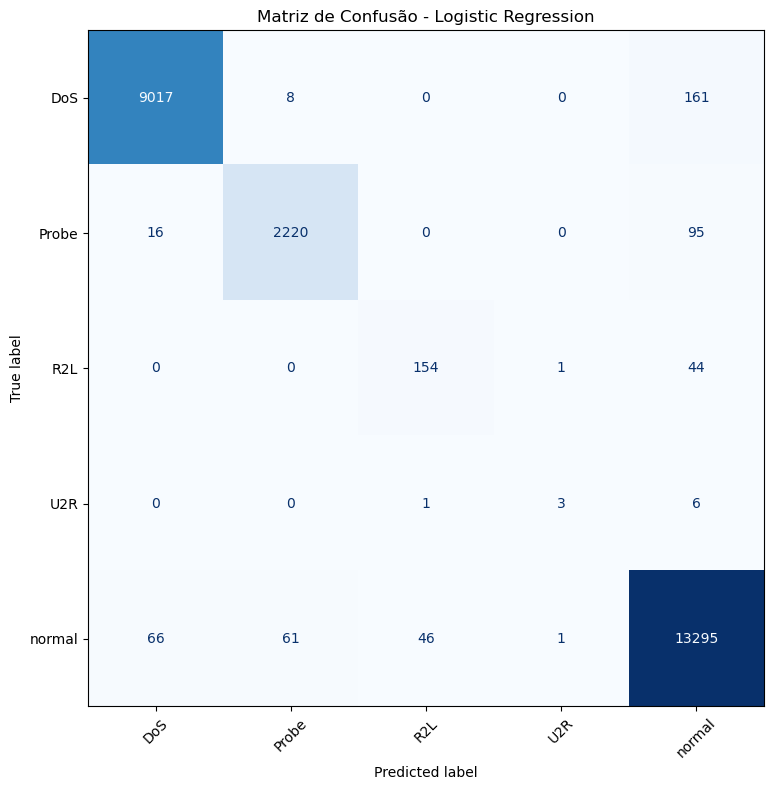

In [18]:
# Label encoding
le = LabelEncoder()
y_val_enc = le.fit_transform(y_val)
y_pred_enc = le.transform(y_pred)

# Probabilidades para AUC
y_proba = best_logreg.predict_proba(X_val)

# Métricas principais
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro')
recall = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')
rmse = np.sqrt(mean_squared_error(y_val_enc, y_pred_enc))

# FPR e FNR
cm = confusion_matrix(y_val_enc, y_pred_enc)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

fpr = np.mean(FP / (FP + TN + 1e-10))
fnr = np.mean(FN / (FN + TP + 1e-10))
tpr = recall  # já calculado

# AUC (ROC)
try:
    auc = roc_auc_score(y_val_enc, y_proba, multi_class='ovr', average='macro')
except Exception:
    auc = None

# Impressão dos resultados
print("==== Avaliação Global (Logistic Regression) ====")
print(f"Acurácia:         {accuracy:.4f}")
print(f"Precisão:         {precision:.4f}")
print(f"Recall (TPR):     {recall:.4f}")
print(f"F1-Score:         {f1:.4f}")
print(f"FPR (média):      {fpr:.4f}")
print(f"FNR (média):      {fnr:.4f}")
print(f"RMSE:             {rmse:.4f}")
print(f"AUC (ROC):        {auc:.4f}" if auc is not None else "AUC (ROC):        Não aplicável")

print("\n==== Relatório por Categoria ====")
print(classification_report(y_val, y_pred, digits=4))

# Matriz de confusão com labels
labels = sorted(y_val.unique())
cm = confusion_matrix(y_val, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45, ax=ax, colorbar=False)
plt.title("Matriz de Confusão - Logistic Regression")
plt.grid(False)
plt.tight_layout()
plt.show()

==== Relatório Binário (normal vs attack) ====
              precision    recall  f1-score   support

      normal     0.9775    0.9871    0.9823     13469
      attack     0.9850    0.9739    0.9794     11726

    accuracy                         0.9809     25195
   macro avg     0.9812    0.9805    0.9808     25195
weighted avg     0.9810    0.9809    0.9809     25195



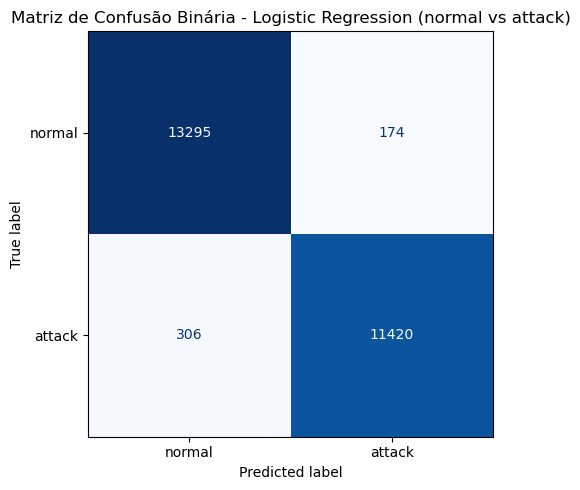

In [19]:
y_val_bin = y_val.apply(lambda x: 0 if x == "normal" else 1)
y_pred_bin = pd.Series(y_pred, index=y_val.index).apply(lambda x: 0 if x == "normal" else 1)

# Relatório binário
print("==== Relatório Binário (normal vs attack) ====")
print(classification_report(y_val_bin, y_pred_bin, target_names=["normal", "attack"], digits=4))

# Matriz de confusão binária
cm_bin = confusion_matrix(y_val_bin, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=["normal", "attack"])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax, colorbar=False)
plt.title("Matriz de Confusão Binária - Logistic Regression (normal vs attack)")
plt.grid(False)
plt.tight_layout()
plt.show()

### Teste KDDTest+

In [20]:
best_logreg = LogisticRegression(
    C=5.0,
    class_weight=None,
    max_iter=500,
    penalty='l2',
    solver='saga'
)

best_logreg.fit(X_train_final, y_train_final)
y_pred = best_logreg.predict(X_test_final)

==== Avaliação Global no Conjunto de Teste (Logistic Regression) ====
Acurácia:         0.7469
Precisão:         0.8380
Recall (TPR):     0.5376
F1-Score:         0.5568
FPR (média):      0.0849
FNR (média):      0.4624
RMSE:             1.4369
AUC (ROC):        0.9247

==== Relatório por Categoria ====
              precision    recall  f1-score   support

         DoS     0.9669    0.8101    0.8816      7458
       Probe     0.7256    0.6881    0.7064      2421
         R2L     0.9658    0.0391    0.0752      2887
         U2R     0.8824    0.2239    0.3571        67
      normal     0.6492    0.9269    0.7636      9711

    accuracy                         0.7469     22544
   macro avg     0.8380    0.5376    0.5568     22544
weighted avg     0.8037    0.7469    0.7071     22544



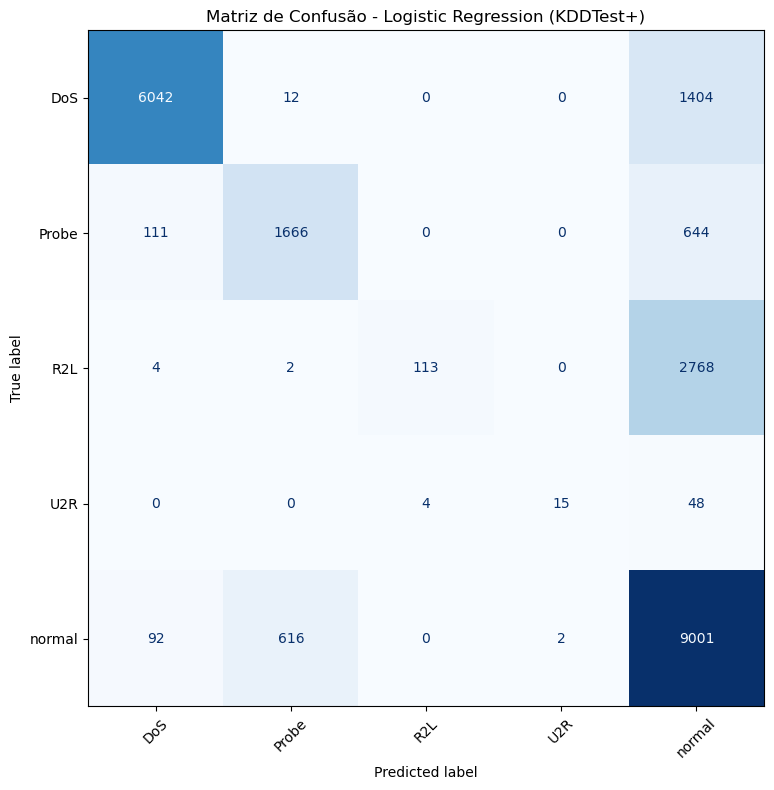

In [21]:
le = LabelEncoder()
y_test_enc = le.fit_transform(y_test_final)
y_pred_enc = le.transform(y_pred)
y_proba = best_logreg.predict_proba(X_test_final)

# Métricas principais
accuracy = accuracy_score(y_test_final, y_pred)
precision = precision_score(y_test_final, y_pred, average='macro')
recall = recall_score(y_test_final, y_pred, average='macro')
f1 = f1_score(y_test_final, y_pred, average='macro')
rmse = np.sqrt(mean_squared_error(y_test_enc, y_pred_enc))

# Confusion matrix para FPR e FNR
cm = confusion_matrix(y_test_enc, y_pred_enc)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

fpr = np.mean(FP / (FP + TN + 1e-10))
fnr = np.mean(FN / (FN + TP + 1e-10))
tpr = recall

# AUC para multi-class
try:
    auc = roc_auc_score(y_test_enc, y_proba, multi_class='ovr', average='macro')
except Exception:
    auc = None

# Exibição
print("==== Avaliação Global no Conjunto de Teste (Logistic Regression) ====")
print(f"Acurácia:         {accuracy:.4f}")
print(f"Precisão:         {precision:.4f}")
print(f"Recall (TPR):     {recall:.4f}")
print(f"F1-Score:         {f1:.4f}")
print(f"FPR (média):      {fpr:.4f}")
print(f"FNR (média):      {fnr:.4f}")
print(f"RMSE:             {rmse:.4f}")
print(f"AUC (ROC):        {auc:.4f}" if auc is not None else "AUC (ROC):        Não aplicável")

# Relatório detalhado por categoria
print("\n==== Relatório por Categoria ====")
print(classification_report(y_test_final, y_pred, digits=4))

# Matriz de confusão multiclass
labels = sorted(y_test_final.unique())
cm = confusion_matrix(y_test_final, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45, ax=ax, colorbar=False)
plt.title("Matriz de Confusão - Logistic Regression (KDDTest+)")
plt.grid(False)
plt.tight_layout()
plt.show()